# **Objectif Business et hypothèses**
Objectif Business Améliorer l'expérience de paiement afin que la variante B (nouvelle version) augmente le taux de conversion au niveau utilisateur par rapport au contrôle A (ancienne version) pendant la période de test.

Primary Metric (PM): Conversion Rate (CR) Définition : Proportion d'utilisateurs uniques exposés qui enregistrent au moins un événement d'achat/conversion pendant la période de l'expérience.

Formule : CR = (nombre d'utilisateurs uniques ayant effectué une conversion = 1) ÷ (nombre d'utilisateurs uniques exposés)

Unité de randomisation/d'analyse : utilisateur (Chaque utilisateur est compté une seule fois ; la première exposition détermine son groupe.)

Attribution :

Compter au maximum une conversion par utilisateur. -Les conversions doivent avoir lieu après la première exposition et pendant la période d'expérimentation.
Pourquoi le CR ?

Directement lié à l'objectif.
Hypotheses Null (H₀): p_B − p_A ≤ 0 (La variante B n'améliore pas le CR par rapport à la variante A) Alternative (H₁): p_B − p_A > 0 (La variante B améliore le CR par rapport à la variante A)

Paramètres statistiques (pré-engagement) Signification : α = 0,05 Objectif de puissance : 1 − β = 0,80 Effet minimum détectable (relatif) : δ_rel = +5 % (c'est-à-dire p_B ≥ 1,05 × p_A) Règle de décision (pour la métrique principale) Rejeter H₀ et « valider » si :

valeur p ≤ α, et augmentation observée ≥ δ_rel, et les garde-fous (par exemple, taux d'erreur, vitesse de la page) ne sont pas enfreints

# **Paramètres statistiques**

In [15]:
# Global experiment settings
ALPHA = 0.05 # significance level
POWER = 0.80 # target power
MDE_REL = 0.05 # +5% relative lift
ALT = 'smaller' # one-sided test for B > A given our order [A, B] in the test (p_A < p_B);

UNIT = 'user' # randomization/analysis unit
ALLOC_TARGET = 0.50 # expected traffic share for B (e.g., 0.50 for 50/50)

# Optional guardrail thresholds
GUARDRAILS = {
'error_rate_max': None,
'page_load_ms_max': None,
}

# **Data Load**

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Machine_Learning/ab_data.csv.zip"

extract_path = "/content/AB_data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


print("Contenu du dossier :", os.listdir(extract_path))

Contenu du dossier : ['ab_data.csv']


In [5]:
import pandas as pd

csv_path = os.path.join(extract_path, "ab_data.csv")
df = pd.read_csv(csv_path)

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# **Basic Cleaning & Derivations**

In [7]:
# the experiment window
raw = df.copy()
ts_min = raw['timestamp'].min()   # earliest
ts_max = raw['timestamp'].max()   # latest
print(ts_min, ts_max)

2017-01-02 13:42:05.378582 2017-01-24 13:41:54.460509


In [8]:
# Ensure group labels are standard
raw['group'] = raw['group'].str.upper().str.strip().replace({'CONTROL':'A','TREATMENT':'B'})

# Drop duplicates at the exposure level (Here we assume one row per user per experiment)
exp = raw.drop_duplicates(subset=['user_id'], keep='first').copy()

# Quick checks
exp['group'].value_counts(), exp.isna().mean()

(group
 B    145352
 A    145232
 Name: count, dtype: int64,
 user_id         0.0
 timestamp       0.0
 group           0.0
 landing_page    0.0
 converted       0.0
 dtype: float64)

# **Pre‑Launch Sanity Checks**
Goal: verify randomization and logging are correct.

In [9]:
# Traffic split sanity: expect ~50/50
counts = exp['group'].value_counts()
print(counts)

# Binomial test around 50%
from statsmodels.stats.proportion import binom_test
p_hat = counts['B'] / counts.sum()
# Hypothesis test for the traffic split (H0: true B share = ALLOC_TARGET (0.50))
pval_split = binom_test(counts['B'], counts.sum(), ALLOC_TARGET, alternative='two-sided')
print({'p_hat_B': p_hat, 'pval_split': pval_split})

group
B    145352
A    145232
Name: count, dtype: int64
{'p_hat_B': np.float64(0.5002064807422294), 'pval_split': np.float64(0.8252830277277096)}


the observed share of B traffic matches the expected share (50%) pval_split is not small (> 0.05), the split is consistent with the plan (e.g., ~50/50), and we can proceed.

# **Power & Sample Size Planning**
Picking a minimum detectable effect (MDE) that is practically meaningful.

In [10]:
# Imports & config
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

# p0 = Conversion rate for group A (baseline) ,  mde_rel = desired relative lift
p0 = exp.loc[exp['group']=='A', 'converted'].mean()    # mean = proportion of 1s
alpha = ALPHA
power = POWER
mde_rel = MDE_REL # 5% relative lift
p1 = p0 * (1 + mde_rel)   # target rate for group B

# Approx sample size per group (for a two-sample z-test)
effect_size = (p1 - p0) / np.sqrt(p0*(1-p0))   # convert the absolute lift (p1 − p0) into standard-deviation units using the Bernoulli SD at baseline
n_per_group = NormalIndPower().solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1, alternative=ALT)  # ratio=1 -> equal allocation A:B
print({'baseline': p0, 'target': p1, 'n_per_group_needed': np.ceil(n_per_group)})

{'baseline': np.float64(0.12029717968491792), 'target': np.float64(0.12631203866916382), 'n_per_group_needed': array([10.])}


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/power.py:135: RuntimeWarning: invalid value encountered in sqrt
  pow_ += stats.norm.cdf(crit - d*np.sqrt(nobs)/sigma)
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


# Primary Analysis – Conversion Rate (Proportion Test)
z-score, p-value and lift

In [11]:
# Aggregate by group
agg = exp.groupby('group').agg(users=('user_id','nunique'), conversions=('converted','sum'))
agg['cr'] = agg['conversions'] / agg['users']   # conversion rate per group
print(agg)

# Prepare inputs for the z-test
count = agg.loc[['A','B'], 'conversions'].to_numpy()           # number of “successes” (conversions) per group
nobs = agg.loc[['A','B'], 'users'].to_numpy()                  # sample sizes per group (users)
stat, pval = proportions_ztest(count, nobs, alternative=ALT)   # returns stat (z-score) and pval (p-value)

# Compute lifts (effect sizes)
lift_abs = agg.loc['B','cr'] - agg.loc['A','cr']   # absolute lift in conversion rate
lift_rel = lift_abs / agg.loc['A','cr']            # relative lift vs control


print({'z_stat': stat, 'p_value': pval, 'lift_abs': lift_abs, 'lift_rel_%': 100*lift_rel})

        users  conversions        cr
group                               
A      145232        17471  0.120297
B      145352        17274  0.118843
{'z_stat': np.float64(1.2083846739740718), 'p_value': np.float64(0.8865503339193361), 'lift_abs': np.float64(-0.001454645698457463), 'lift_rel_%': np.float64(-1.2092101429704898)}


In [12]:
import numpy as np
from scipy.stats import norm

pA = agg.loc['A','cr']; pB = agg.loc['B','cr']
nA = agg.loc['A','users']; nB = agg.loc['B','users']
diff = pB - pA
se = np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB)
z = norm.ppf(0.975)  # 95% two-sided
ci = (diff - z*se, diff + z*se)
print({'diff_abs': diff, 'CI95': ci, 'rel_%': 100*diff/pA})

{'diff_abs': np.float64(-0.001454645698457463), 'CI95': (np.float64(-0.00381403693080908), np.float64(0.0009047455338941539)), 'rel_%': np.float64(-1.2092101429704898)}


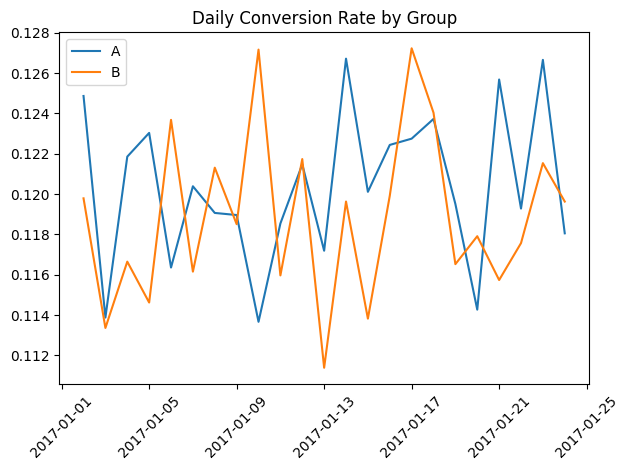

In [13]:
# Time series of daily CR by group (sanity for novelty/seasonality)
exp['timestamp'] = pd.to_datetime(exp['timestamp'])
exp['date'] = exp['timestamp'].dt.date
by_day = exp.groupby(['date','group']).agg(conversions=('converted','sum'), users=('user_id','nunique'))
by_day['cr'] = by_day['conversions']/by_day['users']
by_day = by_day.reset_index()


# If plotting is desired (requires matplotlib)
import matplotlib.pyplot as plt
for g in ['A','B']:
    sub = by_day[by_day['group']==g]
    plt.plot(sub['date'], sub['cr'], label=g)
plt.legend(); plt.title('Daily Conversion Rate by Group'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Report Snippet

In [14]:
ci_lo, ci_hi = [float(v) for v in np.round(ci, 6)]

summary = {
'n_A': int(agg.loc['A','users']),
'n_B': int(agg.loc['B','users']),
'cr_A': float(agg.loc['A','cr']),
'cr_B': float(agg.loc['B','cr']),
'lift_abs': float(lift_abs),
'lift_rel_%': float(100*lift_rel),
'p_value': float(pval),
'ci_rel_%': (100*ci_lo, 100*ci_hi)
}


pd.Series(summary)

,0
n_A,145232
n_B,145352
cr_A,0.120297
cr_B,0.118843
lift_abs,-0.001455
lift_rel_%,-1.20921
p_value,0.88655
ci_rel_%,"(-0.3814, 0.0905)"


Final decision (α = 0.05)
Decision: Do Not Ship Variant B

Reason: The point estimate is negative (≈ −0.145 percentage points), the 95% confidence interval for the absolute lift is [−0.381 pp, +0.091 pp], and p = 0.8866.

This means:

The effect is not statistically significant There is no sufficient evidence that Variant B performs better than Control A Conclusion: Keep Control A.